In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

2025-08-08 12:31:21.012134: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 12:31:21.964711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 12:31:28.403133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
saved_df = pd.read_csv("fashion-clip.csv")
print(len(saved_df))
saved_df.nunique()

3705


category            5
subcategory        35
img              3507
fit                 6
length              4
front_opening       2
neck               11
sleeves             4
hood                2
fastener            6
material            5
design              3
embeddings       3705
dtype: int64

In [3]:
column_names = ['category',
 'subcategory',
 'fit',
 'length',
 'front_opening',
 'neck',
 'sleeves',
 'hood',
 'fastener',
 'material',
 'design']

In [4]:
saved_df["img"] = saved_df["category"] + "/" + saved_df["img"]

In [ ]:
# Dictionary to store encoders for later decoding or inference use
# encode to integers 
label_encoders = {}
for col in column_names:
    le = LabelEncoder()
    saved_df[col] = le.fit_transform(saved_df[col].astype(str))
    label_encoders[col] = le

In [14]:
for enc in label_encoders:
    print('"',enc,'"', ":",label_encoders[enc].classes_, ",")

" category " : ['Blazers and Tailoring' 'Casual T-shirts' 'Knits & Hoodies'
 'Shirts & Blouses' 'Tops'] ,
" subcategory " : ['Button-Up Shirt' 'Camisole' 'Cardigan' 'Cold Shoulder' 'Cropped Blazer'
 'Cropped Sweatshirt' 'Double-Breasted Blazer' 'Formal Shirt'
 'Henley Shirt' 'Open Cowl Neck Sweater' 'Oversized Shirt'
 'Oversized T-Shirt' 'Peplum Blouse' 'Peplum Top' 'Polo Shirt'
 'Pullover Hoodie' 'Regular T-Shirt' 'Shell Top' 'Single-Breasted Blazer'
 'Sleeveless T-Shirt' 'Slim-Fit T-Shirt' 'Sweater' 'Sweatshirt' 'Tank Top'
 'Tunic' 'Tunic Shirt' 'Turtleneck Sweater' 'V-Neck Cardigan'
 'V-Neck Sweater' 'V-Neck T-Shirt' 'Vest' 'Workout Tank' 'Wrap Blouse'
 'Zip Hoodie' 'Zipped Sweatshirt'] ,
" fit " : ['Loose Fit' 'Oversized Fit' 'Regular Fit' 'Relaxed Fit' 'Slim Fit'
 'Tailored Fit'] ,
" length " : ['Cropped' 'Hip Length' 'Tunic Length' 'Waist Length'] ,
" front_opening " : ['False' 'True'] ,
" neck " : ['Boat Neck' 'Collared' 'Cowl Neck' 'Crew Neck' 'Mock Neck' 'No neck'
 'Off-the-Sh

In [47]:
# !!!!!!!!!! GLOBAL PARAMS !!!!!!!!!!!!!!!!

# EfficientNetV2B0 - 22.58 MB
# NASNetMobile - 16.29 MB
# EfficientNetB0 - 15 MB
# MobileNetV2 - 8.61 MB
# MobileViT - 4.9 MB - Their findings suggest that, performance-wise, MobileViT is better than other models with the same or higher complexity (MobileNetV3, for example), while being efficient on mobile devices.
# MobileNetV3Small - 3.58 MB
model_name ="MobileNetV3Small"
input_size = 224
input_Vit_size = 256
data_path = "/home/cat/projects/CV-stuff/datasets/multilabel_fashion_dataset/upperwear/"

In [ ]:

def make_dataset(images_path, df, label_cols, batch_size=32, shuffle=True, model=model_name, in_size=input_size, in_vit_size=input_Vit_size):
    # Don't convert to NumPy!
    path_ds = tf.data.Dataset.from_tensor_slices(df["img"].astype(str))
    label_ds = tf.data.Dataset.from_tensor_slices(
        {col: df[col].astype("int32") for col in label_cols}  # dictionary for structured output
    )

    # Zip paths and labels
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    # Load and preprocess lazily
    def process(path, label_dict):
        filepath = tf.strings.join([images_path, path])
        image = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(image, channels=3)
        match model:
            case "MobileNetV2":                
                image = tf.image.resize(image, (in_size, in_size))
                image = keras.applications.mobilenet_v2.preprocess_input(image)
            case "MobileViT":
                image = tf.image.resize(image, (in_vit_size, in_vit_size))
            case _:
                # expect their inputs to be float tensors of pixels with values in the [0-255] range
                # A floating point numpy.array or backend-native tensor, 4D with 3 color channels, with values in the range [0, 255]
                image = tf.image.resize(image, (in_size, in_size))
        return image, label_dict

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [49]:
train_df, test_df = train_test_split(saved_df, train_size=0.9, shuffle=True, random_state=1)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=1)

In [50]:
train_ds = make_dataset(data_path, train_df, column_names, batch_size=32, shuffle=True)
val_ds = make_dataset(data_path, val_df, column_names, batch_size=32, shuffle=False)
test_ds = make_dataset(data_path, test_df, column_names, batch_size=32, shuffle=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name node, model, outside of any statement?
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name node, model, outside of any statement?
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name node, model, outside of any statement?
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 

In [51]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
for images, labels in train_ds.take(84):  # Take one batch
    print("Images shape:", images.shape)
    print("Labels keys:", labels.keys())
    
    # for key, value in labels.items():
    #     print(f"{key}: {value.numpy()[:5]}")  # Show first 5 labels for each key
for images, labels in val_ds.take(21):  # Take one batch
    print("Images shape:", images.shape)
    print("Labels keys:", labels.keys())
for images, labels in test_ds.take(1):  # Take one batch
    print("Images shape:", images.shape)
    print("Labels keys:", labels.keys())

84
21
12
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'lengt

2025-08-07 17:22:16.323625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'front_opening', 'neck', 'sleeves', 'hood', 'fastener', 'material', 'design'])
Images shape: (32, 224, 224, 3)
Labels keys: dict_keys(['category', 'subcategory', 'fit', 'length', 'fron

2025-08-07 17:22:16.602175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-07 17:22:16.656774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [54]:
from mobilevit import create_mobilevit
def create_model(df):
    pretrained_model = None

    match model_name:
        case "MobileNetV2":
            pretrained_model = tf.keras.applications.MobileNetV2(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )
        case "MobileViT":
            pretrained_model = create_mobilevit(input_Vit_size)
        case "MobileNetV3Small":
            pretrained_model = tf.keras.applications.MobileNetV3Small(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )
        case _:
            pretrained_model = tf.keras.applications.EfficientNetB0(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )    

    pretrained_model.trainable = False

    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(64, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(32, activation='relu')(x)

    # example of multi-output model
    category = tf.keras.layers.Dense(df["category"].nunique(), activation="softmax", name='category')(x)
    subcategory = tf.keras.layers.Dense(df["subcategory"].nunique(),  activation="softmax", name='subcategory')(x)
    fit = tf.keras.layers.Dense(df["fit"].nunique(), activation="softmax", name='fit')(x)
    length = tf.keras.layers.Dense(df["length"].nunique(),  activation="softmax", name='length')(x)
    front_opening = tf.keras.layers.Dense(df["front_opening"].nunique(), activation="softmax", name='front_opening')(x)
    neck = tf.keras.layers.Dense(df["neck"].nunique(),  activation="softmax", name='neck')(x)
    sleeves = tf.keras.layers.Dense(df["sleeves"].nunique(), activation="softmax", name='sleeves')(x)
    hood = tf.keras.layers.Dense(df["hood"].nunique(),  activation="softmax", name='hood')(x)
    fastener = tf.keras.layers.Dense(df["fastener"].nunique(), activation="softmax", name='fastener')(x)
    material = tf.keras.layers.Dense(df["material"].nunique(),  activation="softmax", name='material')(x)
    design = tf.keras.layers.Dense(df["design"].nunique(), activation="softmax", name='design')(x)

    outputs = [category , subcategory , fit , length , front_opening , neck , sleeves, hood, fastener, material, design]
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    # print(model.summary())
    return model

In [55]:
model = create_model(saved_df)

In [56]:
model.compile(
    loss = {
        "category": keras.losses.SparseCategoricalCrossentropy(),
        "subcategory": keras.losses.SparseCategoricalCrossentropy(),
        "fit" : keras.losses.SparseCategoricalCrossentropy() ,
        "length" : keras.losses.SparseCategoricalCrossentropy() ,
        "front_opening" : keras.losses.SparseCategoricalCrossentropy() ,
        "neck" : keras.losses.SparseCategoricalCrossentropy() ,
        "sleeves" : keras.losses.SparseCategoricalCrossentropy(),
        "hood" : keras.losses.SparseCategoricalCrossentropy() ,
        "fastener" : keras.losses.SparseCategoricalCrossentropy() ,
        "material" : keras.losses.SparseCategoricalCrossentropy() ,
        "design" : keras.losses.SparseCategoricalCrossentropy()
    },
    metrics = {
        "category": keras.metrics.SparseCategoricalAccuracy(),
        "subcategory": keras.metrics.SparseCategoricalAccuracy(),
        "fit" : keras.metrics.SparseCategoricalAccuracy() ,
        "length" : keras.metrics.SparseCategoricalAccuracy() ,
        "front_opening" : keras.metrics.SparseCategoricalAccuracy() ,
        "neck" : keras.metrics.SparseCategoricalAccuracy() ,
        "sleeves" : keras.metrics.SparseCategoricalAccuracy(),
        "hood" : keras.metrics.SparseCategoricalAccuracy() ,
        "fastener" : keras.metrics.SparseCategoricalAccuracy() ,
        "material" : keras.metrics.SparseCategoricalAccuracy() ,
        "design" : keras.metrics.SparseCategoricalAccuracy()
    },
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [57]:
from matplotlib import pyplot as plt


def plot_history(hist):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  for key in hist.history:
    if "accuracy" in key:  # includes both train and val
        plt.plot(hist.history[key], label=key)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

In [58]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size=32, callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1754580168.922070  197403 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3422', 140 bytes spill stores, 140 bytes spill loads

I0000 00:00:1754580168.951811  197399 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3422', 344 bytes spill stores, 336 bytes spill loads

I0000 00:00:1754580169.086118  197406 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7542', 40 bytes spill stores, 40 bytes spill loads



82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - category_sparse_categorical_accuracy: 0.4472 - design_sparse_categorical_accuracy: 0.7247 - fastener_sparse_categorical_accuracy: 0.6005 - fit_sparse_categorical_accuracy: 0.4032 - front_opening_sparse_categorical_accuracy: 0.6228 - hood_sparse_categorical_accuracy: 0.8582 - length_sparse_categorical_accuracy: 0.9189 - loss: 13.7113 - material_sparse_categorical_accuracy: 0.3863 - neck_sparse_categorical_accuracy: 0.3735 - sleeves_sparse_categorical_accuracy: 0.5825 - subcategory_sparse_categorical_accuracy: 0.0913

I0000 00:00:1754580181.269876  197598 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3422', 104 bytes spill stores, 104 bytes spill loads



84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - category_sparse_categorical_accuracy: 0.4511 - design_sparse_categorical_accuracy: 0.7292 - fastener_sparse_categorical_accuracy: 0.6032 - fit_sparse_categorical_accuracy: 0.4058 - front_opening_sparse_categorical_accuracy: 0.6255 - hood_sparse_categorical_accuracy: 0.8596 - length_sparse_categorical_accuracy: 0.9196 - loss: 13.6362 - material_sparse_categorical_accuracy: 0.3900 - neck_sparse_categorical_accuracy: 0.3777 - sleeves_sparse_categorical_accuracy: 0.5861 - subcategory_sparse_categorical_accuracy: 0.0947

I0000 00:00:1754580195.817368  197871 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1485', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1754580195.972333  197869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1485', 344 bytes spill stores, 344 bytes spill loads



84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - category_sparse_categorical_accuracy: 0.4529 - design_sparse_categorical_accuracy: 0.7314 - fastener_sparse_categorical_accuracy: 0.6045 - fit_sparse_categorical_accuracy: 0.4070 - front_opening_sparse_categorical_accuracy: 0.6268 - hood_sparse_categorical_accuracy: 0.8603 - length_sparse_categorical_accuracy: 0.9199 - loss: 13.5999 - material_sparse_categorical_accuracy: 0.3919 - neck_sparse_categorical_accuracy: 0.3797 - sleeves_sparse_categorical_accuracy: 0.5879 - subcategory_sparse_categorical_accuracy: 0.0964 - val_category_sparse_categorical_accuracy: 0.8321 - val_design_sparse_categorical_accuracy: 0.9895 - val_fastener_sparse_categorical_accuracy: 0.8426 - val_fit_sparse_categorical_accuracy: 0.6522 - val_front_opening_sparse_categorical_accuracy: 0.9220 - val_hood_sparse_categorical_accuracy: 0.9595 - val_length_sparse_categorical_accuracy: 0.9625 - val_loss: 6.5375 - val_material_sparse_categorical_accuracy: 0.7691 - val_neck_spars

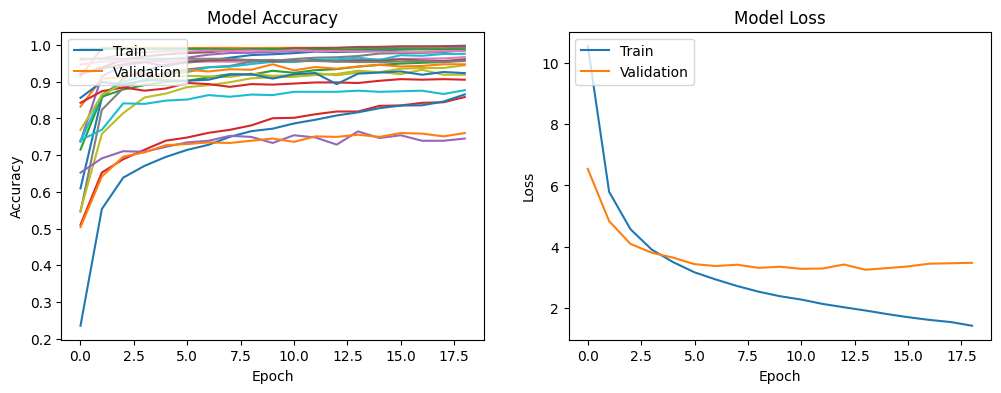

In [59]:
plot_history(history)

In [60]:
results = model.evaluate(test_ds)
print("Test results:", results)

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - category_sparse_categorical_accuracy: 0.9264 - design_sparse_categorical_accuracy: 0.9790 - fastener_sparse_categorical_accuracy: 0.8636 - fit_sparse_categorical_accuracy: 0.7333 - front_opening_sparse_categorical_accuracy: 0.9502 - hood_sparse_categorical_accuracy: 0.9836 - length_sparse_categorical_accuracy: 0.9196 - loss: 3.5086 - material_sparse_categorical_accuracy: 0.9079 - neck_sparse_categorical_accuracy: 0.8806 - sleeves_sparse_categorical_accuracy: 0.9565 - subcategory_sparse_categorical_accuracy: 0.7011

I0000 00:00:1754580304.225076  199984 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1485', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1754580304.414795  199975 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1485', 336 bytes spill stores, 336 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 754ms/step - category_sparse_categorical_accuracy: 0.9288 - design_sparse_categorical_accuracy: 0.9813 - fastener_sparse_categorical_accuracy: 0.8647 - fit_sparse_categorical_accuracy: 0.7309 - front_opening_sparse_categorical_accuracy: 0.9518 - hood_sparse_categorical_accuracy: 0.9829 - length_sparse_categorical_accuracy: 0.9236 - loss: 3.4997 - material_sparse_categorical_accuracy: 0.9075 - neck_sparse_categorical_accuracy: 0.8812 - sleeves_sparse_categorical_accuracy: 0.9494 - subcategory_sparse_categorical_accuracy: 0.7020
Test results: [3.452915668487549, 0.9380053877830505, 0.9892183542251587, 0.8706199526786804, 0.7250673770904541, 0.9568732976913452, 0.9811320900917053, 0.9353099465370178, 0.9056603908538818, 0.8840970396995544, 0.9272237420082092, 0.7035040259361267]


In [84]:

y_true = {}
y_pred = {}
y_pred_yop = {}


In [81]:
len(test_ds)

12

In [93]:
for images, labels in test_ds.take(1):
    pred = model.predict([images])
    # print(classification_report(labels['category'], pred[0]))
    # print(confusion_matrix(y_true['category'], y_pred['category']))
    
    for ind, image in enumerate(images):
        # image_np = image.numpy().astype(np.uint8)
    #     pil_image = Image.fromarray(image_np)
    #     display(pil_image)        
        for i, col in enumerate(column_names):
            res = tf.argmax(pred[i][ind], axis=0).numpy()
            true_label_tensor = labels[col][ind].numpy()
            top_k_preds = tf.argsort(pred[i][ind], direction='DESCENDING').numpy()[:5]
            # print(res,true_label_tensor, top_k_preds)
            if col not in y_true:
                y_true[col] = []
            y_true[col].append(true_label_tensor)
            if col not in y_pred:
                y_pred[col] = []
            y_pred[col].append(res)
            if col not in y_pred_yop:
                y_pred_yop[col] = []
            y_pred_yop[col].append(top_k_preds)
            # pred_label = label_encoders[col].inverse_transform([res])
            # true_label = label_encoders[col].inverse_transform([true_label_tensor])
            # print(pred_label[0], "True label:", true_label)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
# def top_k_classification_report(y_true, top_k_preds, k=5):
#     y_pred_topk = []

#     for true, topk in zip(y_true, top_k_preds):
#         if true in topk:
#             y_pred_topk.append(true)  # pretend model predicted correctly
#         else:
#             y_pred_topk.append(topk[-1])  # use top-1 as fallback "wrong" class

#     print(classification_report(y_true, y_pred_topk))

In [83]:
print(classification_report(y_true['subcategory'], y_pred['subcategory']))
print(confusion_matrix(y_true['subcategory'], y_pred['subcategory']))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         8
           7       0.67      1.00      0.80         8
          11       0.00      0.00      0.00         4
          15       1.00      1.00      1.00         8
          16       0.88      1.00      0.93        28
          17       1.00      0.50      0.67         8
          18       0.71      1.00      0.83        20
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         4
          22       1.00      1.00      1.00         4
          23       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         4

    accuracy                           0.75       128
   macro avg       0.52      0.52      0.51       128
weighted avg       0.72      0.75      0.72       128

[[20  0  0  4  0  0  0  0

/home/cat/.env/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cat/.env/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cat/.env/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cat/.e

In [ ]:
# model.save('MobileNetV3Small_test.keras')

NameError: name 'model' is not defined

In [ ]:
# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.

# Can be run in google colab, here crashes

# def convertToTFLite(keras_model, name):
#   converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
#   tflmodel = converter.convert()
#   file = open( name , 'wb' )
#   file.write( tflmodel )

# saved_model = keras.models.load_model('MobileNetV3Small_test.keras')
# convertToTFLite(saved_model, "MobileNetV3Small_test.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpu2065ne7/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2065ne7/assets


: 

In [73]:
# datasets i have:
# cloth_dataset - images in separate folders
# clothing dataset-full - images in one folder with a .csv file (image,sender_id,label,kids, where label is a category: skirt, pants, etc.)
# fashion-clothes - images in separate folders (only coats, hoodies, men suits, dresses)
# fashionMNIST - images in separate folders (0. T-shirt/top, 1. Trouser, 2. Pullover, 3. Dress, 4. Coat, 5. Sandal, 6. Shirt, 7. Sneaker, 8. Bag, 9. Ankle boot)
# new-data-fashio - images in separate folders (black or blue dress, pants, shirt, shoes and shorts)

In [74]:
# import kagglehub
# downloaded
# path = kagglehub.dataset_download("dqmonn/zalando-store-crawl") #zalando clothes - folders
# kagglehub.dataset_download("hammaadali/real-fashion") #in folders
# kagglehub.dataset_download("mayukh18/fashion200k-dataset") #in folders, there are also some labels
# kagglehub.dataset_download("kritanjalijain/outfititems") #in folders
# kagglehub.dataset_download("sivaprasads/fashion-dataset") #- only images without folders or file
# kagglehub.dataset_download("anchalsekhrii/fashion-classification-dataset") #in folders
# kagglehub.dataset_download("aloofzebra03/clothes-classification-final-aug-split") #in folders
# path = kagglehub.dataset_download("kaborg15/vibrent-clothes-rental-dataset") #- maybe????  CC BY 4.0 - csv file very difficult to process, has labrls in an array


# kagglehub.dataset_download("tuannguyenvananh/fashion-crawled-images")# in folders, has culottes is big 81 gb